In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import sklearn.preprocessing as pre
from pandas import DataFrame
from pandas import concat
from scipy.stats import linregress as lr
from scipy.signal import find_peaks as find_peaks
from scipy.fftpack import fft, ifft,rfft
from sklearn.decomposition import PCA
from scipy.optimize import curve_fit
import pickle
from sklearn.model_selection import KFold
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier, RandomTreesEmbedding, AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# 1. Feature Calculation

In [2]:
# Globals
COLUMNS = np.array(['Slope_minmax', 
           'PeakVal1_error', 'PeakVal2_error', 'PeakHt1_error', 'PeakHt2_error', 
           'Min1_window', 'Min2_window', 'Max1_window', 'Max2_window', 'Var1_window', 'Var2_window', 'Mean1_window', 'Mean2_window', 
           'Sig_coef1','Sig_coef2','Sig_coef3','Sig_coef4',
           'Max_fft', 'Min_fft', 'Mean_fft', 'Var_fft'
          ])

In [3]:
def CalcFeatureSet1(cgmNorm_np, cgmSeries_np):
    maxs = np.argmax(cgmNorm_np, axis=1)
    mins = [np.argmin(cgmNorm_np[i, maxs[i]:])+maxs[i] for i in range(len(maxs))]

    slopes = []
    time_diffs = []
    for i in range(len(maxs)):
        slope = (cgmNorm_np[i][maxs[i]]-cgmNorm_np[i][mins[i]])/(cgmSeries_np[maxs[i]]-cgmSeries_np[mins[i]])
        time_diffs.append(cgmSeries_np[maxs[i]]-cgmSeries_np[mins[i]])
        slopes.append(slope)

    slopes = np.nan_to_num(slopes)
    time_diffs = np.nan_to_num(time_diffs)
    reg_window_size = 4
    reg_errors = []
    peak_values = []
    peak_heights = []
    peak_time_diffs = []
    peak_times = []
    for j in range(len(cgmNorm_np)):
        errors = np.array([])
        for i in range(len(cgmNorm_np[j])-reg_window_size):
            times = cgmSeries_np[i:i+reg_window_size-1]
            if np.isnan(times).any():
                errors = np.append(errors, -1)
                continue
            coeffs = np.polyfit(times, cgmNorm_np[j][i:i+reg_window_size-1], 1)
            poly = np.poly1d(coeffs)
            error = poly(cgmSeries_np[i+reg_window_size])-cgmNorm_np[j][i+reg_window_size];
            errors = np.append(errors, error)
        peaks, height_dict = find_peaks(errors, height = 0)
        heights = height_dict['peak_heights']
        sorted_args = heights.argsort()
        peaks = peaks[sorted_args]
        peaks = peaks[-2:]
        heights = heights[sorted_args]
        heights = heights[-2:]
        values = cgmNorm_np[j][peaks+reg_window_size-1]
        times1 = cgmSeries_np[peaks+reg_window_size]
        times2 = cgmSeries_np[peaks+reg_window_size-1]
        reg_errors.append(errors)
        while(len(values) < 2):
            values = np.append(values, 0)
            heights = np.append(heights, 0)
            times1 = np.append(times, 0)
            times2 = np.append(times2, 0)
        peak_values.append(values)
        peak_heights.append(heights)
        peak_time_diffs.append(times1)
        peak_times.append(times2)
    reg_errors = np.array(reg_errors)
    matrix = []
    for i in range(0, len(cgmNorm_np)):
        matrix_row = np.array([])
        matrix_row = np.append(matrix_row, slopes[i])
#         matrix_row = np.append(matrix_row, time_diffs[i])
        matrix_row = np.append(matrix_row, peak_values[i])
        matrix_row = np.append(matrix_row, peak_heights[i])
#         matrix_row = np.append(matrix_row, peak_times[i])
        matrix.append(matrix_row)
    matrix = np.array(matrix)
    return matrix

In [4]:
def CalcFeatureSet2(cgmNorm_np, cgmSeries_np):
    window_mins = []
    window_maxs = []
    window_means = []
    window_vars = []
    for i in range(0, len(cgmNorm_np)):
        window_input = DataFrame(cgmNorm_np[i][::-1])
        width=5
        shifted=window_input.shift(width - 1)
        window=shifted.rolling(window=width)
        dataframe=concat([window.var(), window.min(),  window.mean(), window.max() ], axis=1)
        dataframe.columns = ['var', 'min', 'mean', 'max']
        window_features = dataframe.nlargest(2,'var')
        window_values = window_features.values
        window_mins.append([window_values[0][1], window_values[1][1]])
        window_maxs.append([window_values[0][3], window_values[1][3]])
        window_vars.append([window_values[0][0], window_values[1][0]])
        window_means.append([window_values[0][2], window_values[1][2]])
    
    matrix = []
    for i in range(0, len(cgmNorm_np)):
        matrix_row = np.array([])
        matrix_row = np.append(matrix_row, window_mins[i])
        matrix_row = np.append(matrix_row, window_maxs[i])
        matrix_row = np.append(matrix_row, window_vars[i])
        matrix_row = np.append(matrix_row, window_means[i])
        matrix.append(matrix_row)
    matrix = np.array(matrix)
    return matrix

In [5]:
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

def CalcFeatureSet3(cgmNorm_np, cgmSeries_np):
    n_series = []
    n_datenum = []
    sig1 = []
    sig2 = []
    sig3 = []
    sig4 = []
    for i in range(0, len(cgmNorm_np)):
        idx = np.isfinite(cgmSeries_np) & np.isfinite(cgmNorm_np[i])
        n_series.append(cgmNorm_np[i][idx])  
        n_datenum.append(cgmSeries_np[idx])
    for i in range(0,len(cgmNorm_np)):
        if(len(n_series[i]) !=0 ):
            try:
                p0 = [max(n_series[i]), np.median(n_datenum[i]),250,min(n_series[i])] 
                popt, pcov = curve_fit(sigmoid, n_datenum[i], n_series[i],p0,method='trf')
            except: 
                popt=[0,0,0,0]

            sig1.append(popt[0])
            sig2.append(popt[1])
            sig3.append(popt[2])
            sig4.append(popt[3])
    
    matrix = []
    for i in range(0, len(cgmNorm_np)):
        matrix_row = np.array([])
        matrix_row = np.append(matrix_row, sig1[i])
        matrix_row = np.append(matrix_row, sig2[i])
        matrix_row = np.append(matrix_row, sig3[i])
        matrix_row = np.append(matrix_row, sig4[i])
        matrix.append(matrix_row)
    matrix = np.array(matrix)
    return matrix

In [6]:
def CalcFeatureSet4(cgmNorm_np, cgmSeries_np):
    Feature_vector=[]
    for i in range(0, len(cgmNorm_np)):
    #FFT
        fastfouriertransform=rfft(cgmNorm_np[i])
        fft_max=np.nanmax(fastfouriertransform)
        s=np.where(fastfouriertransform == fft_max)
        fft_min=np.nanmin(fastfouriertransform)
        s=np.where(fastfouriertransform == fft_min)
        fft_mean=np.nanmean(fastfouriertransform)
        fft_variance=np.nanvar(fastfouriertransform)
        Feature_vector.append(np.array([fft_max,fft_min,fft_mean,fft_variance]))
    matrix = np.array(Feature_vector)
    return matrix

In [7]:
def MergedFeatures(cgmNorm_np, cgmSeries_np):
    feature_set_1 = CalcFeatureSet1(cgmNorm_np, cgmSeries_np)
    feature_set_2 = CalcFeatureSet2(cgmNorm_np, cgmSeries_np)
    feature_set_3 = CalcFeatureSet3(cgmNorm_np, cgmSeries_np)
    feature_set_4 = CalcFeatureSet4(cgmNorm_np, cgmSeries_np)
    features = np.concatenate((feature_set_1, feature_set_2), axis=1)
    features = np.concatenate((features, feature_set_3), axis=1)
    features = np.concatenate((features, feature_set_4), axis=1)
    features = np.nan_to_num(features)
    return features

In [8]:
def GenerateDF(features, columns):
    feature_df = pd.DataFrame(features, columns=columns)
    return feature_df

In [9]:
def NormalizeDF(feature_df, columns, max_scale):
    for i in columns:
        feature_df[i] = feature_df[i]/max_scale[i]
    return feature_df
#     means = feature_df.mean(axis=0)
#     large_means = np.argwhere(means>1).flatten()
#     small_means = np.argwhere(means<-1).flatten()
#     for i in large_means:
#         base = int(np.log10(means[i]))+1
#         if base > 1:
#             feature_df[columns[i]] = np.nan_to_num(np.log10(feature_df[columns[i]].replace(0, np.nan)))/base
#     for i in small_means:
#         base = int(np.log10(np.abs(means[i])))+1
#         if base > 1:
#             feature_df[columns[i]] = np.sign(feature_df[columns[i]])*np.nan_to_num(np.log10(np.abs(feature_df[columns[i]].replace(0, np.nan))))/base
# #     print(large_means)
#     return feature_df

In [10]:
file_no = [1, 2, 3, 4, 5]

In [11]:
cgmData = pd.read_csv("ComparisonData/mealData" + str(1) + '.csv', names=list(range(50)))
for i in file_no[1:]:
    cgm = pd.read_csv("ComparisonData/mealData" + str(i) + '.csv', names=list(range(50)))
    cgmData = cgmData.append(cgm)
cgmData = cgmData.dropna(axis='columns', how='all')
cgmData = cgmData.mask(cgmData.eq(-1)).ffill(axis=1)
cgmData = cgmData.mask(cgmData.eq(-1)).bfill(axis=1)

zero_entries = cgmData.isna().any(axis=1)
cgmData = cgmData[zero_entries == False]

cgmValues_np = cgmData.values
cgmNorm_np = cgmValues_np/400.0

length = len(cgmNorm_np[0])
cgmSeries_np = [0.0833*(length-i-1) for i in range(0, length)]
cgmSeries_np = np.array(cgmSeries_np)
features = MergedFeatures(cgmNorm_np, cgmSeries_np)
features_df = GenerateDF(features, COLUMNS)
max_scale = features_df.abs().max(axis=0)
max_scale.to_pickle('DataScale.pkl')
normal_df = NormalizeDF(features_df, COLUMNS, max_scale)
display(normal_df)
normal_df.to_csv('MealFeatures.csv', index=False)

cgmData = pd.read_csv("ComparisonData/Nomeal" + str(1) + '.csv', names=list(range(50)))
for i in file_no[1:]:
    cgm = pd.read_csv("ComparisonData/Nomeal" + str(i) + '.csv', names=list(range(50)))
    cgmData = cgmData.append(cgm)
cgmData = cgmData.dropna(axis='columns', how='all')
cgmData = cgmData.mask(cgmData.eq(-1)).ffill(axis=1)
cgmData = cgmData.mask(cgmData.eq(-1)).bfill(axis=1)

zero_entries = cgmData.isna().any(axis=1)
cgmData = cgmData[zero_entries == False]

cgmValues_np = cgmData.values
cgmNorm_np = cgmValues_np/400.0

length = len(cgmNorm_np[0])
cgmSeries_np = [0.0833*(length-i-1) for i in range(0, length)]
cgmSeries_np = np.array(cgmSeries_np)
features = MergedFeatures(cgmNorm_np, cgmSeries_np)
features_df = GenerateDF(features, COLUMNS)
normal_df = NormalizeDF(features_df, COLUMNS, max_scale)
display(normal_df)
normal_df.to_csv('NoMealFeatures.csv', index = False)

/home/anikl9705/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/anikl9705/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


,Slope_minmax,PeakVal1_error,PeakVal2_error,PeakHt1_error,PeakHt2_error,Min1_window,Min2_window,Max1_window,Max2_window,Var1_window,...,Mean1_window,Mean2_window,Sig_coef1,Sig_coef2,Sig_coef3,Sig_coef4,Max_fft,Min_fft,Mean_fft,Var_fft
0,0.223958,0.786632,0.6925,0.379195,0.418994,0.672222,0.663889,0.7300,0.726817,0.151981,...,0.702505,0.684127,-0.000179,0.157098,0.005127,0.001196,0.704449,-0.305146,0.634014,0.501904
1,0.181818,0.370180,0.5000,0.197987,0.242086,0.419444,0.391667,0.4900,0.466165,0.091495,...,0.451461,0.428571,-0.000178,0.105077,0.499994,0.000705,0.377450,-0.368154,0.351433,0.148848
2,0.193182,0.519280,0.4700,0.308725,0.275605,0.250000,0.230556,0.3975,0.358396,0.190450,...,0.328288,0.292593,0.000544,0.101382,0.003870,0.000346,0.376598,-0.543992,0.284399,0.155170
3,0.245536,0.383033,0.5350,0.305369,0.175047,0.341667,0.327778,0.4225,0.403509,0.098461,...,0.382568,0.360847,0.000301,0.147579,0.124742,0.000625,0.433015,-0.226763,0.418339,0.191966
4,0.100216,0.336761,0.4000,0.171141,0.100559,0.311111,0.297222,0.3650,0.348371,0.049465,...,0.338205,0.322222,0.000349,0.079098,0.002012,0.000404,0.374979,-0.273501,0.318875,0.145182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,0.000000,0.431877,0.4100,0.147651,0.096834,0.483333,0.480556,0.5050,0.481203,0.033843,...,0.484864,0.476190,-0.000050,0.100701,0.167965,0.000747,0.440430,-0.016335,0.473434,0.193096
245,0.114583,0.421594,0.7875,0.174497,0.474860,0.675000,0.636111,0.7775,0.739348,0.188891,...,0.720772,0.687302,-0.000417,0.100093,0.125973,0.001138,0.563832,-0.089779,0.700013,0.323749
246,0.000000,0.910026,0.7875,0.248322,0.474860,0.675000,0.636111,0.7775,0.739348,0.188891,...,0.720772,0.687302,-0.000536,0.100893,0.499999,0.001435,0.715528,-0.181405,0.835001,0.522252
247,0.258102,0.796915,0.5950,0.265101,0.163873,0.394444,0.425000,0.5225,0.551378,0.191386,...,0.452505,0.500000,0.000961,0.102585,0.001567,0.000517,0.604568,-0.738501,0.472639,0.393181


,Slope_minmax,PeakVal1_error,PeakVal2_error,PeakHt1_error,PeakHt2_error,Min1_window,Min2_window,Max1_window,Max2_window,Var1_window,...,Mean1_window,Mean2_window,Sig_coef1,Sig_coef2,Sig_coef3,Sig_coef4,Max_fft,Min_fft,Mean_fft,Var_fft
0,0.144231,0.501285,0.3575,0.154362,0.093110,0.447222,0.461111,0.4725,0.488722,0.034883,...,0.456159,0.480423,0.000627,0.108393,0.001025,0.000377,0.390830,-0.348937,0.337304,0.165106
1,0.043750,0.228792,0.2575,0.204698,0.232775,0.250000,0.250000,0.2625,0.263158,0.013334,...,0.251566,0.261905,0.000106,0.056948,0.000748,0.000317,0.227373,-0.045013,0.223039,0.053624
2,0.035511,0.221080,0.2350,0.144295,0.093110,0.205556,0.211111,0.2150,0.218045,0.006290,...,0.208246,0.217989,0.000164,0.021526,0.000920,0.000238,0.216550,-0.055635,0.207839,0.048761
3,0.062500,0.275064,0.2350,0.137584,0.229050,0.277778,0.305556,0.3550,0.370927,0.072390,...,0.313152,0.342857,-0.000035,0.247183,0.249993,0.000470,0.277314,-0.029355,0.332700,0.079420
4,0.187500,0.380463,0.6275,0.164430,0.290503,0.558333,0.536111,0.6175,0.601504,0.098383,...,0.587161,0.566667,-0.000273,0.980133,0.249876,0.000750,0.442986,-0.055481,0.543379,0.204876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,0.222656,0.562982,0.5600,0.419463,0.391061,0.566667,0.552778,0.6175,0.598997,0.083775,...,0.588727,0.571429,0.000141,0.149809,0.014424,0.000924,0.565877,-0.091022,0.569134,0.331637
241,0.142241,0.455013,0.5125,0.362416,0.420857,0.466667,0.466667,0.5475,0.538847,0.145482,...,0.512004,0.495238,0.000000,0.000000,0.000000,0.000000,0.522328,-0.240149,0.479270,0.287802
242,0.250000,0.334190,0.3550,0.161074,0.121043,0.308333,0.313889,0.3250,0.335840,0.018507,...,0.315240,0.331746,0.611069,-0.186050,0.249984,-0.611593,0.319584,-0.017950,0.353250,0.105370
243,0.200521,0.544987,0.5625,0.224832,0.202980,0.397222,0.372222,0.4725,0.446115,0.084555,...,0.434760,0.411640,0.010025,-0.172258,0.000601,-0.008907,0.525652,-0.323542,0.417438,0.295973


# 2. PCA Calculation

In [12]:
PCA_filename = 'PCA.pkl'

In [13]:
def GeneratePCA(data, PCA_filename):
    pca = PCA(n_components=5)
    pca.fit(data)
    components = pca.components_
    variances = pca.explained_variance_
    x = [i for i in range(0, len(components[0]))]
    for i in range(0, 5):
        plt.figure()
        plt.bar(x, components[i])
        plt.xticks(np.arange(len(components[0])), x, rotation=90)
        plt.show()
        positives = np.array(np.argwhere(components[i] > 0).flatten())
        positive_sorted = np.argsort(components[i][:])
    PCA_file = open(PCA_filename, 'wb')
    pickle.dump(pca, PCA_file)
    PCA_file.close()

In [14]:
def Transform(data, PCA_filename):
    PCA_file = open(PCA_filename, 'rb')
    pca = pickle.load(PCA_file)
    PCA_file.close()
    return pca.transform(data)

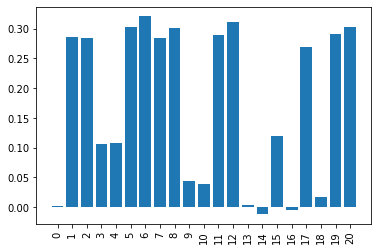

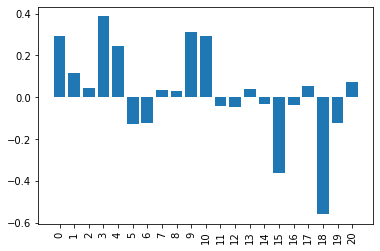

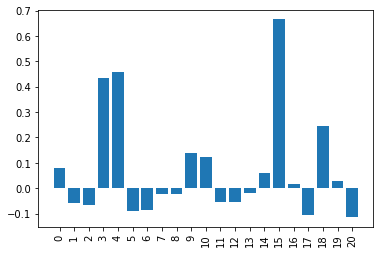

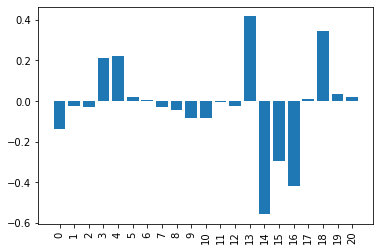

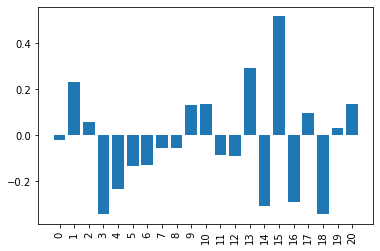

In [15]:
mealData = pd.read_csv('MealFeatures.csv')
noMealData = pd.read_csv('NoMealFeatures.csv')

GeneratePCA(mealData, PCA_filename)
mealTransform = Transform(mealData, PCA_filename)
noMealTransform = Transform(noMealData, PCA_filename)

In [16]:
mealLabels = np.ones((mealTransform.shape[0], 1))
noMealLabels = np.zeros((noMealTransform.shape[0], 1))

mealDataWithLabels = np.concatenate((mealTransform, mealLabels), axis=1)
noMealDataWithLabels = np.concatenate((noMealTransform, noMealLabels), axis=1)

dataset = np.concatenate((mealDataWithLabels, noMealDataWithLabels), axis=0)
np.random.shuffle(dataset)

# 3. Training Models

In [17]:
class Classifiers:
    def __init__(self):
        self.Anirudh_filename = 'Anirudh.pkl'
        self.Omkar_filename = 'Omkar.pkl'
        self.Ananth_filename = 'Ananth.pkl'
        self.Vedant_filename = 'Vedant.pkl'
        return
    
    def genClassifier_Anirudh(self):
        self.Anirudh_SVM = SVC(C=1.0, kernel='rbf', gamma='scale', probability=True)
        self.Anirudh_KNN = KNeighborsClassifier(n_neighbors=5, weights='distance', p=2)
        self.Anirudh_classifier = VotingClassifier(estimators=[('SVM', self.Anirudh_SVM), ('KNN', self.Anirudh_KNN)], voting='soft')
          
    def genClassifier_Vedant(self):
        kernel = 1.0 * RBF(1.0)
        self.Vedant_gpc = GaussianProcessClassifier(kernel=kernel,random_state=0)
        self.Vedant_mlp = MLPClassifier(solver='lbfgs',activation ='tanh', alpha=1e-5,hidden_layer_sizes=(4,2), random_state=1)
        self.Vedant_classifier = VotingClassifier(estimators=[('gpc', self.Vedant_gpc), ('mlp', self.Vedant_mlp)],voting='soft')

    def genClassifier_Omkar(self):
        self.Omkar_rf1 = RandomForestClassifier(n_estimators=50, max_depth=6,random_state=0)#.fit(dataset[train][:, :-1], dataset[train][:, -1])
        self.Omkar_rf2 = AdaBoostClassifier(n_estimators=50, random_state=0)#.fit(dataset[train][:, :-1], dataset[train][:, -1])
        kernel = 1.0 * RBF(1.0)
        self.Omkar_rf3 = GaussianProcessClassifier(kernel=kernel,random_state=0)#.fit(dataset[train][:, :-1], dataset[train][:, -1])
        self.Omkar_rf4 = SVC(kernel='rbf', gamma='auto')#.fit(dataset[train][:, :-1], dataset[train][:, -1])

        self.Omkar_classifier = VotingClassifier(estimators=[('rf', self.Omkar_rf1), ('ab', self.Omkar_rf2), ('gpc', self.Omkar_rf3), ('svm',self.Omkar_rf4)], voting='hard', weights=[2,0.9,0.5,0.3])

    def genClassifier_Ananth(self):
        self.Ananth_dt=DecisionTreeClassifier(max_depth=5)
        self.Ananth_gnb=GaussianNB()
        self.Ananth_classifier = VotingClassifier(estimators=[('dt',self.Ananth_dt), ('gnb',self.Ananth_gnb)],voting='soft')
        
    def trainClassifier_Anirudh(self, train_data):
        self.genClassifier_Anirudh()
        self.Anirudh_classifier.fit(train_data[:, :-1], train_data[:, -1])
        
    def trainClassifier_Vedant(self, train_data):
        self.genClassifier_Vedant()
        self.Vedant_classifier.fit(train_data[:, :-1], train_data[:, -1])
        
    def trainClassifier_Omkar(self, train_data):
        self.genClassifier_Omkar()
        self.Omkar_classifier.fit(train_data[:, :-1], train_data[:, -1])
        
    def trainClassifier_Ananth(self, train_data):
        self.genClassifier_Ananth()
        self.Ananth_classifier.fit(train_data[:, :-1], train_data[:, -1])
        
    def validateClassifier_Anirudh(self, test_data):
        labels = self.Anirudh_classifier.predict(test_data[:, :-1])
        return labels
    
    def validateClassifier_Vedant(self, test_data):
        labels = self.Vedant_classifier.predict(test_data[:, :-1])
        return labels
    
    def validateClassifier_Omkar(self, test_data):
        labels = self.Omkar_classifier.predict(test_data[:, :-1])
        return labels
    
    def validateClassifier_Ananth(self, test_data):
        labels = self.Ananth_classifier.predict(test_data[:, :-1])
        return labels
    
    def loadClassifier_Anirudh(self):
        save_file = open(self.Anirudh_filename, 'rb')
        self.Anirudh_classifier = pickle.load(save_file)
        save_file.close()
        return
    
    def loadClassifier_Vedant(self):
        save_file = open(self.Vedant_filename, 'rb')
        self.Vedant_classifier = pickle.load(save_file)
        save_file.close()
        return
    
    def loadClassifier_Omkar(self):
        save_file = open(self.Omkar_filename, 'rb')
        self.Omkar_classifier = pickle.load(save_file)
        save_file.close()
        return
    
    def loadClassifier_Ananth(self):
        save_file = open(self.Ananth_filename, 'rb')
        self.Ananth_classifier = pickle.load(save_file)
        save_file.close()
        return
    
    def loadAllClassifiers():
        self.loadClassifier_Anirudh()
        self.loadClassifier_Vedant()
        self.loadClassifier_Omkar()
        self.loadClassifier_Ananth()
        
    def saveClassifier_Anirudh(self):
        save_file = open(self.Anirudh_filename, 'wb')
        pickle.dump(self.Anirudh_classifier, save_file)
        save_file.close()
        return
    
    def saveClassifier_Vedant(self):
        save_file = open(self.Vedant_filename, 'wb')
        pickle.dump(self.Vedant_classifier, save_file)
        save_file.close()
        return
    
    def saveClassifier_Omkar(self):
        save_file = open(self.Omkar_filename, 'wb')
        pickle.dump(self.Omkar_classifier, save_file)
        save_file.close()
        return
    
    def saveClassifier_Ananth(self):
        save_file = open(self.Ananth_filename, 'wb')
        pickle.dump(self.Ananth_classifier, save_file)
        save_file.close()
        return

In [18]:
def evaluate(test_labels, labels):
    TP = 0.0
    FP = 0.0
    TN = 0.0
    FN = 0.0
    base = len(labels)
    for i in range(len(labels)):
        if labels[i] == 1:
            if test_labels[i] == 1:
                TP += 1
            else:
                FP += 1
        else:
            if test_labels[i] == 0:
                TN += 1
            else:
                FN += 1
    acc = (TP+TN)/base
    if TP+FP == 0:
        prec = 1.0
    else:
        prec = (TP)/(TP+FP)
    if TP+FN == 0:
        rec = 1.0
    else:
        rec = (TP)/(TP+FN)
    return acc, prec, rec

In [19]:
no_k = 10
kf = KFold(no_k)
total_acc = 0.0
max_acc = 0.0
total_prec = 0.0
total_rec = 0.0
models = Classifiers()

print("############ Model 1 (Anirudh) ##############")
for train, test in kf.split(dataset):
    models.trainClassifier_Anirudh(dataset[train])
    labels = models.validateClassifier_Anirudh(dataset[test])
    acc, prec, rec = evaluate(dataset[test][:, -1], labels)
    max_acc = max(max_acc, acc)
    if max_acc == acc:
        models.saveClassifier_Anirudh()
    total_acc += acc
    total_prec += prec
    total_rec += rec
    print("Acc = %f, Prec = %f, Rec = %f, F1 = %f" %(acc, prec, rec, 2*prec*rec/(prec+rec)))
print("MEAN: Acc = %f, Prec = %f, Rec = %f, F1 = %f" %(total_acc/no_k, total_prec/no_k, total_rec/no_k, 2*total_prec*total_rec/(no_k*(total_prec+total_rec))))

total_acc = 0.0
max_acc = 0.0
total_prec = 0.0
total_rec = 0.0
print("############ Model 2 (Vedant) ##############")
for train, test in kf.split(dataset):
    models.trainClassifier_Vedant(dataset[train])
    labels = models.validateClassifier_Vedant(dataset[test])
    acc, prec, rec = evaluate(dataset[test][:, -1], labels)
    max_acc = max(max_acc, acc)
    if max_acc == acc:
        models.saveClassifier_Vedant()
    total_acc += acc
    total_prec += prec
    total_rec += rec
    print("Acc = %f, Prec = %f, Rec = %f, F1 = %f" %(acc, prec, rec, 2*prec*rec/(prec+rec)))
print("MEAN: Acc = %f, Prec = %f, Rec = %f, F1 = %f" %(total_acc/no_k, total_prec/no_k, total_rec/no_k, 2*total_prec*total_rec/(no_k*(total_prec+total_rec))))

total_acc = 0.0
max_acc = 0.0
total_prec = 0.0
total_rec = 0.0
print("############ Model 3 (Omkar) ##############")
for train, test in kf.split(dataset):
    models.trainClassifier_Omkar(dataset[train])
    labels = models.validateClassifier_Omkar(dataset[test])
    acc, prec, rec = evaluate(dataset[test][:, -1], labels)
    max_acc = max(max_acc, acc)
    if max_acc == acc:
        models.saveClassifier_Omkar()
    total_acc += acc
    total_prec += prec
    total_rec += rec
    print("Acc = %f, Prec = %f, Rec = %f, F1 = %f" %(acc, prec, rec, 2*prec*rec/(prec+rec)))
print("MEAN: Acc = %f, Prec = %f, Rec = %f, F1 = %f" %(total_acc/no_k, total_prec/no_k, total_rec/no_k, 2*total_prec*total_rec/(no_k*(total_prec+total_rec))))

total_acc = 0.0
max_acc = 0.0
total_prec = 0.0
total_rec = 0.0
print("############ Model 4 (Ananth) ##############")
for train, test in kf.split(dataset):
    models.trainClassifier_Ananth(dataset[train])
    labels = models.validateClassifier_Ananth(dataset[test])
    acc, prec, rec = evaluate(dataset[test][:, -1], labels)
    max_acc = max(max_acc, acc)
    if max_acc == acc:
        models.saveClassifier_Ananth()
    total_acc += acc
    total_prec += prec
    total_rec += rec
    print("Acc = %f, Prec = %f, Rec = %f, F1 = %f" %(acc, prec, rec, 2*prec*rec/(prec+rec)))
print("MEAN: Acc = %f, Prec = %f, Rec = %f, F1 = %f" %(total_acc/no_k, total_prec/no_k, total_rec/no_k, 2*total_prec*total_rec/(no_k*(total_prec+total_rec))))


############ Model 1 (Anirudh) ##############
Acc = 0.760000, Prec = 0.750000, Rec = 0.807692, F1 = 0.777778
Acc = 0.720000, Prec = 0.678571, Rec = 0.791667, F1 = 0.730769
Acc = 0.760000, Prec = 0.615385, Rec = 0.888889, F1 = 0.727273
Acc = 0.820000, Prec = 0.920000, Rec = 0.766667, F1 = 0.836364
Acc = 0.836735, Prec = 0.766667, Rec = 0.958333, F1 = 0.851852
Acc = 0.673469, Prec = 0.560000, Rec = 0.736842, F1 = 0.636364
Acc = 0.714286, Prec = 0.814815, Rec = 0.709677, F1 = 0.758621
Acc = 0.816327, Prec = 0.781250, Rec = 0.925926, F1 = 0.847458
Acc = 0.775510, Prec = 0.724138, Rec = 0.875000, F1 = 0.792453
Acc = 0.673469, Prec = 0.692308, Rec = 0.692308, F1 = 0.692308
MEAN: Acc = 0.754980, Prec = 0.730313, Rec = 0.815300, F1 = 0.770470
############ Model 2 (Vedant) ##############
Acc = 0.760000, Prec = 0.791667, Rec = 0.730769, F1 = 0.760000
Acc = 0.800000, Prec = 0.705882, Rec = 1.000000, F1 = 0.827586
Acc = 0.820000, Prec = 0.680000, Rec = 0.944444, F1 = 0.790698
Acc = 0.760000, Prec 